In [24]:
import pandas as pd
import numpy as np

df = pd.read_csv('Datasets/csv_files/uk_housing_2020.csv', encoding='latin1', thousands=',')
df.head()

,AREACD,AREANM,earnings,Estimated Population mid-2019,Year ending Mar 2020,2019 people per sq. km
0,E06000001,Hartlepool,557.2,93663,128500,999
1,E06000002,Middlesbrough,556.8,140980,137000,2616
2,E06000003,Redcar and Cleveland,506.2,137150,132950,560
3,E06000004,Stockton-on-Tees,537.3,197348,150000,963
4,E06000005,Darlington,519.3,106803,144000,541


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   AREACD                         336 non-null    object 
 1   AREANM                         336 non-null    object 
 2   earnings                       335 non-null    float64
 3   Estimated Population mid-2019  336 non-null    int64  
 4   Year ending Mar 2020           336 non-null    int64  
 5   2019 people per sq. km         336 non-null    int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 15.9+ KB


In [26]:
df.rename(columns={'AREACD': 'area_code', 'AREANM': 'area_name', 'earnings': 'earnings_per_week', 'Year ending Mar 2020': 'median_house_price_paid_mar_2020', '2019 people per sq. km': 'density_per_sq.km_2019', 'Estimated Population mid-2019': 'population_2019' }, inplace=True)

In [27]:
df.describe()

,earnings_per_week,population_2019,median_house_price_paid_mar_2020,density_per_sq.km_2019
count,335.000000,3.360000e+02,3.360000e+02,336.000000
mean,564.967463,1.769043e+05,2.719484e+05,1721.967262
std,83.505875,1.199554e+05,1.388520e+05,2598.663864
min,427.000000,2.224000e+03,9.000000e+04,25.000000
25%,516.500000,1.014192e+05,1.750000e+05,215.750000
50%,549.700000,1.383630e+05,2.400000e+05,603.500000
75%,590.300000,2.153825e+05,3.215000e+05,2314.500000
max,1103.100000,1.141816e+06,1.300000e+06,16427.000000


In [35]:
df.isnull().sum()

area_code                           0
area_name                           0
earnings_per_week                   1
population_2019                     0
median_house_price_paid_mar_2020    0
density_per_sq.km_2019              0
income_cat                          1
dtype: int64

In [37]:
df = df.dropna()
df.isnull().sum()

area_code                           0
area_name                           0
earnings_per_week                   0
population_2019                     0
median_house_price_paid_mar_2020    0
density_per_sq.km_2019              0
income_cat                          0
dtype: int64

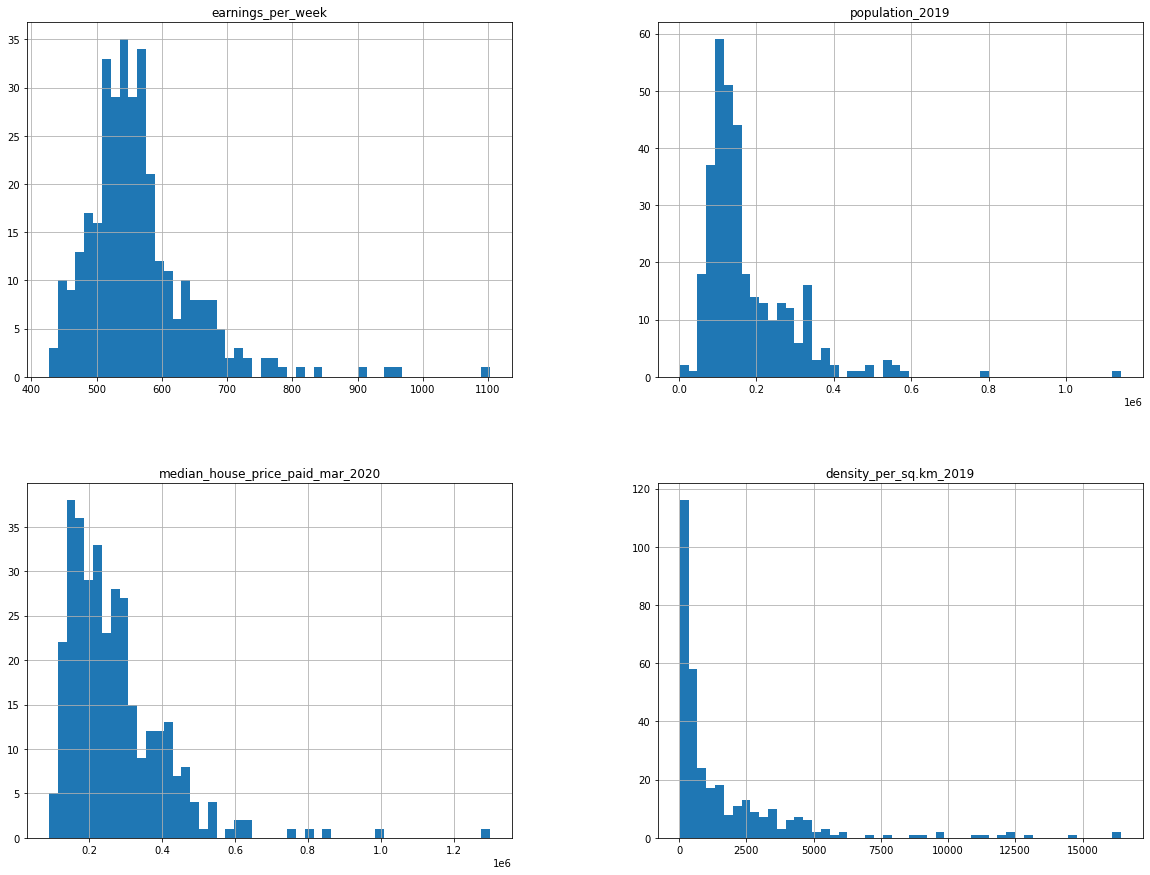

In [28]:
%matplotlib inline  
## The 'matplotlib inline' only works in Jupyter Notebook  ##
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

In [29]:
df['earnings_per_week'].min()

427.0

### Overall, the histograms are 'tail-heavy' ie they are left-wards leaning (positively skewed). This may make it harder for some Machine Learning algorithms to detect patterns. We might be able to transform these attributes to have more of a Gaussian bell-shaped distribution.

# Creating a Test Set

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X = df[['earnings_per_week','density_per_sq.km_2019']]
Y = df[['median_house_price_paid_mar_2020']]

x_train, x_test, y_train, y_test = train_test_split(X,Y, train_size=0.8, test_size=0.2, random_state=10)

In [20]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

268
68
268
68


In [21]:
x_train

,earnings_per_week,density_per_sq.km_2019
25,558.2,3282
308,806.7,11045
227,502.5,154
105,564.8,260
59,474.7,186
...,...,...
123,608.1,4507
320,451.5,41
15,536.2,4830
125,532.7,536


### However, we may have an issue here. SImply because our datasets is not large enough to be considered as a large dataset, we run the risk of introducing a significant sampling bias. We want the significant or important attributes to be representative of the overall population. If you run a certain survey at a purely random sampling to a population of 51% female, 49% male, you have about 12% chance of sampling a skewed test set that either makes less than 49% female, or 54% female. Overall, the results would be significantly biased.

### To mitigate this problem, we will use another type of train and test set.

<AxesSubplot:>

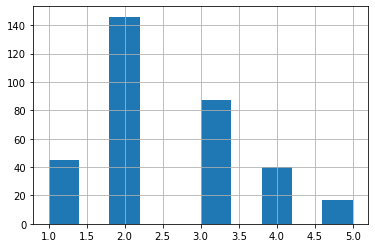

In [31]:
df['income_cat'] = pd.cut(df['earnings_per_week'], bins=[420., 490., 560., 630., 700., np.inf], labels=[1,2,3,4,5])
df['income_cat'].hist()

In [33]:
from sklearn.model_selection import StratifiedShuffleSplit

In [40]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(df, df['income_cat']):
    strat_train_set = df.iloc[train_index]
    strat_test_set = df.iloc[test_index]

In [48]:
rand_train_x, rand_test_x, rand_train_y, rand_test_y = train_test_split(df['income_cat'],df['median_house_price_paid_mar_2020'], train_size=0.8, test_size=0.2, random_state=10)

In [53]:
Stratified = strat_test_set['income_cat'].value_counts() / len(strat_test_set)

In [54]:
Overall = df['income_cat'].value_counts() / len(df)

In [55]:
Random = rand_test_x.value_counts() / len(rand_test_x)

In [56]:
data = {'Overall': Overall,
        'Stratified': Stratified,
        'Random':Random}

df_sampling_bias_comp = pd.DataFrame(data)
df_sampling_bias_comp

,Overall,Stratified,Random
2,0.435821,0.432836,0.477612
3,0.259701,0.268657,0.343284
1,0.134328,0.134328,0.074627
4,0.119403,0.119403,0.059701
5,0.050746,0.044776,0.044776


In [59]:
df_sampling_bias_comp['Rand. %error'] = (df_sampling_bias_comp['Random'] - df_sampling_bias_comp['Overall'])*100 / df_sampling_bias_comp['Overall']
df_sampling_bias_comp['Strat. %error'] = (df_sampling_bias_comp['Stratified'] - df_sampling_bias_comp['Overall'])*100 / df_sampling_bias_comp['Overall']

In [60]:
df_sampling_bias_comp

,Overall,Stratified,Random,Strat. %error,Rand. %error
2,0.435821,0.432836,0.477612,-0.684932,9.589041
3,0.259701,0.268657,0.343284,3.448276,32.183908
1,0.134328,0.134328,0.074627,0.000000,-44.444444
4,0.119403,0.119403,0.059701,0.000000,-50.000000
5,0.050746,0.044776,0.044776,-11.764706,-11.764706


### Lets now drop these income_cat attribute

In [61]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

C:\Users\User\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [62]:
df.head()

,area_code,area_name,earnings_per_week,population_2019,median_house_price_paid_mar_2020,density_per_sq.km_2019,income_cat
0,E06000001,Hartlepool,557.2,93663,128500,999,2
1,E06000002,Middlesbrough,556.8,140980,137000,2616,2
2,E06000003,Redcar and Cleveland,506.2,137150,132950,560,2
3,E06000004,Stockton-on-Tees,537.3,197348,150000,963,2
4,E06000005,Darlington,519.3,106803,144000,541,2
